[View in Colaboratory](https://colab.research.google.com/github/Joovvhan/Master-Thesis/blob/master/src/Prediction_Test_Modified_For_Presentation.ipynb)

In [0]:
# Import library
import os
import glob
import numpy as np

In [2]:
# Mount google drive

from google.colab import drive

drive.mount('/content/gdrive')
os.listdir('gdrive/My Drive/Colab')

Mounted at /content/gdrive


['Data_', 'Model', 'Data']

In [3]:
from keras.models import load_model

# Set model path

modelPath = 'gdrive/My Drive/Colab/Model'

dataPath = 'gdrive/My Drive/Colab/Data'

modelList = glob.glob(modelPath + '/*h5')
    
numberModel = np.inf
    
while numberModel >= len(modelList): 

    for i in range(len(modelList)):
        print('#{:d}: {}'.format(i, modelList[i]))
    
    numberModel = int(input('Type In Your Model Number:\n'))

    if numberModel < len(modelList):
        print('Loading {}'.format(modelList[numberModel]))    
        model = load_model(modelList[numberModel])
        print('Loading Completed')    
    else:
        print('Invalid Model Number\n')
        


Using TensorFlow backend.


#0: gdrive/My Drive/Colab/Model/A3F3P1-A3F3P5_VGG19_10-08-11:28:34.h5
#1: gdrive/My Drive/Colab/Model/A3F3P1-A3F3P5_ResNet50_10-08-10:48:42.h5
#2: gdrive/My Drive/Colab/Model/A3F3P1-A3F3P5_Xception_10-08-05:15:07.h5
#3: gdrive/My Drive/Colab/Model/A3F1P3-A3F5P3_Xception_10-06-17:14:18.h5
#4: gdrive/My Drive/Colab/Model/A3F1P3 vs A3F5P3 ResNet50 10-06 05:30:50.h5
Type In Your Model Number:
3
Loading gdrive/My Drive/Colab/Model/A3F1P3-A3F5P3_Xception_10-06-17:14:18.h5
Loading Completed


In [4]:
creationDate = modelList[numberModel].split('_')[-1].replace('.h5', '')

modelParamList = glob.glob(modelPath + '/*.npy')
modelParam = [param for param in modelParamList if creationDate in param]

print('Parameter npy File List: {}'.format(modelParam))

trainMean = float(np.load([param for param in modelParam if 'mean' in param][0]))
trainStd = float(np.load([param for param in modelParam if 'std' in param][0]))

Parameter npy File List: ['gdrive/My Drive/Colab/Model/std_10-06-17:14:18.npy', 'gdrive/My Drive/Colab/Model/mean_10-06-17:14:18.npy']


In [5]:
dataPath = 'gdrive/My Drive/Colab/Data'

foldersTest = ['A3F1P3', 'A3F2P3', 'A3F3P3', 'A3F4P3', 'A3F5P3']

pathTests = [dataPath + '/' + folder for folder in foldersTest]
print(pathTests)

filesTest = list()

for i in range(len(foldersTest)):
    filesTest = filesTest + (glob.glob(pathTests[i] + '/*.wav'))
    
print(len(filesTest))

['gdrive/My Drive/Colab/Data/A3F1P3', 'gdrive/My Drive/Colab/Data/A3F2P3', 'gdrive/My Drive/Colab/Data/A3F3P3', 'gdrive/My Drive/Colab/Data/A3F4P3', 'gdrive/My Drive/Colab/Data/A3F5P3']
5000


In [6]:
from tqdm import trange
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wf

nsc = 1470
nov = nsc/2
nff = nsc

imgSize = 224

imgsTestList = list()

for i in range(len(pathTests)):

    npyTestPath = glob.glob(pathTests[i] + '/' + '*.npy')
    
    if (len(npyTestPath) == 1):
        imgsTest = np.load(npyTestPath[0])

    else:
        
        filesTest = glob.glob(pathTests[i] + '/*.wav')
        
        imgsTest = np.zeros([len(filesTest), imgSize, imgSize])

        for j in trange(len(filesTest)):
            fs, dataInt16 = wf.read(filesTest[j])
            dataFloat = dataInt16 / (2 ** 15)
            Pxx, _, _, _ = plt.specgram(dataFloat, NFFT=nff, Fs=fs, noverlap=nov, \
                                               window=np.hamming(nsc), cmap='viridis')
            plt.close()
            imgsTest[j, :, :] = 10 * np.log10(Pxx[0:imgSize, :])

        np.save(pathTests[i] + '/' + foldersTest[i] + '.npy', imgsTest)

    print('Test Image Shape From {}: {}'.format(foldersTest[i], imgsTest.shape))    
    
    imgsTestList.append(imgsTest)
    
imgsTestTotal = np.vstack(imgsTestList)

print('Test Image Shape From {}: {}'.format(foldersTest, imgsTestTotal.shape))    
    

Test Image Shape From A3F1P3: (1000, 224, 224)
Test Image Shape From A3F2P3: (1000, 224, 224)
Test Image Shape From A3F3P3: (1000, 224, 224)
Test Image Shape From A3F4P3: (1000, 224, 224)
Test Image Shape From A3F5P3: (1000, 224, 224)
Test Image Shape From ['A3F1P3', 'A3F2P3', 'A3F3P3', 'A3F4P3', 'A3F5P3']: (5000, 224, 224)


In [11]:
imgsTestTotal.shape

(5000, 224, 224)

In [21]:
# Add saving mean and std with model

chunkLength = 500

for i in range(int(len(imgsTestTotal) / chunkLength)):

    imgsTestChunk = imgsTestTotal[i * chunkLength:(i + 1) * chunkLength, :, :]

    testImgsNorm = (imgsTestChunk - trainMean) / trainStd

    testImgsNorm = testImgsNorm.reshape(list(testImgsNorm.shape) + [1])

    X_test = np.stack([testImgsNorm[:, :, :, 0], testImgsNorm[:, :, :, 0], testImgsNorm[:, :, :, 0]], axis = -1)

    Y_pred_chunk = model.predict(X_test, verbose=1)
    
    if i == 0:
        Y_pred = Y_pred_chunk
    else:
        Y_pred = np.vstack((Y_pred, Y_pred_chunk))
    

500/500 [==============================] - 6s 13ms/step


In [13]:
# Y_pred = model.predict(X_test, verbose=1)

500/500 [==============================] - 7s 13ms/step


In [23]:
Y_pred.shape

(5000, 2)

([<matplotlib.axis.YTick at 0x7f4c293aa128>,
 <a list of 4 Text yticklabel objects>)

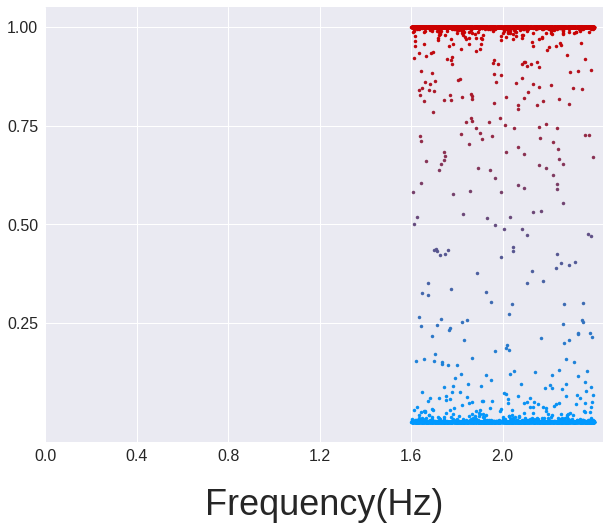

In [50]:
X_ticks = np.zeros(len(Y_pred))

for i in range(len(X_ticks)):
    X_ticks[i] = float(filesTest[i].split('/')[-1].split('_')[1][1:-1])

plt.figure(figsize=(10, 8))
for i in range(len(X_ticks)):
    normalC = np.asarray([0, 0.6, 1])
    faultC = np.asarray([0.8, 0, 0])
    dotC = Y_pred[i, 1] * faultC + (1 - Y_pred[i, 1]) * normalC
    plt.plot(X_ticks[i], Y_pred[i, 1], '.', color=dotC)


plt.xticks([0, 0.4, 0.8, 1.2, 1.6, 2.0], fontsize=16)
plt.xlabel('Frequency(Hz)', fontsize=36, labelpad = 24)

plt.yticks([0.25, 0.5, 0.75, 1.0], fontsize=16)
# plt.ylabel('Fault Probability', fontsize=36, labelpad = 24)
# plt.gca().get_yaxis().set_visible(False)

# Need to match file name with x axis

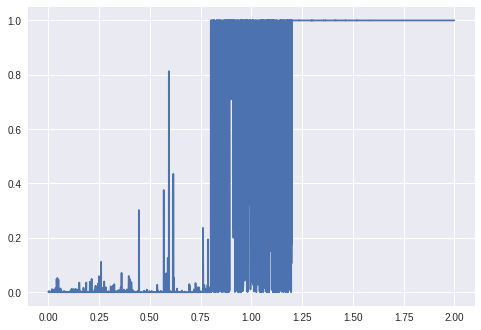

In [48]:
x = np.stack((X_ticks, Y_pred[:, 1])).T
y = np.asarray(sorted(x, key=lambda x: x[0]))
# plt.plot(x[:, 0], x[:, 1])
plt.plot(y[:, 0], y[:, 1])

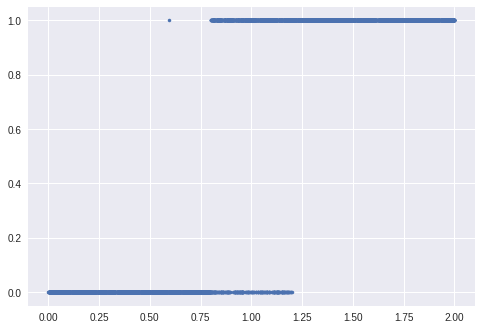

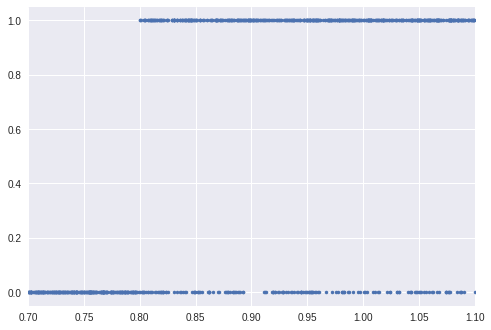

In [51]:
z = [round(val) for val in y[:, 1]]
pit = y[:, 0]
plt.plot(pit, z, '.')
plt.show()

plt.plot(pit, z, '.')
plt.xlim((0.7, 1.1))
plt.show()

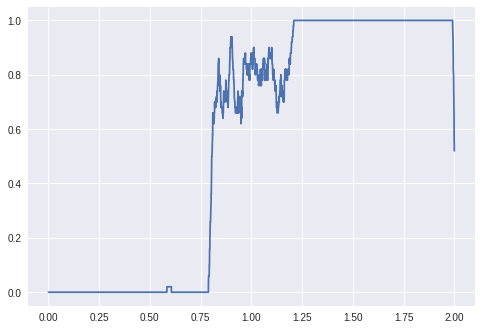

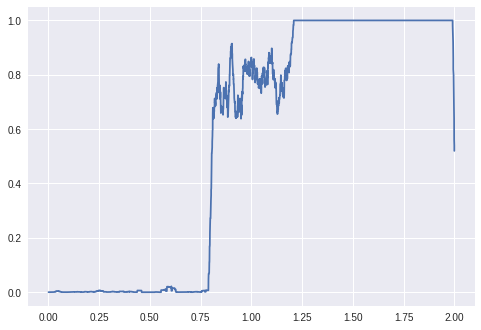

In [52]:
N = 50
zMovMean = np.convolve(z, np.ones((N,))/N, mode='same')
y2MovMean = np.convolve(y[:, 1], np.ones((N,))/N, mode='same')


plt.plot(pit, zMovMean)
plt.show()

plt.plot(pit, y2MovMean)
plt.show()

In [53]:
y[:, 1]
zMovMean

array([0.  , 0.  , 0.  , ..., 0.56, 0.54, 0.52])